In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve
from IPython.display import display, HTML

In [2]:
# Load Data for Modeling
df = pd.read_csv('../Data/DT_1.csv')
display(df)
display(HTML("<b>Target Variable:</b> Account"))
display(df['account'].value_counts(normalize=True).to_frame().reset_index(drop=True).style.hide(axis='columns').format('{:.2%}'))

,wgt,gender,age,ed_lvl,income_q,employed,rural,account,savings,loans,...,agri_sale_3,agri_sale_4,utilities_1,utilities_2,utilities_3,utilities_4,remittances_1,remittances_2,remittances_3,remittances_4
0,0.33,0,18,3,3,1,0,1,0,0,...,False,True,False,True,False,False,False,False,False,True
1,1.33,1,41,1,1,1,1,1,0,0,...,False,True,True,False,False,False,False,False,False,True
2,1.46,1,23,1,2,0,1,1,0,1,...,False,True,False,True,False,False,False,False,False,True
3,0.39,0,17,2,2,1,0,1,0,0,...,False,True,False,False,False,True,False,False,False,True
4,2.42,1,27,1,1,0,1,1,1,0,...,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2890,2.11,1,65,1,1,0,1,1,0,1,...,False,True,False,False,False,True,False,False,False,True
2891,0.70,1,32,1,5,0,1,1,0,0,...,False,True,False,True,False,False,True,False,False,False
2892,1.61,1,18,2,2,0,1,0,0,0,...,False,True,False,False,False,True,False,False,False,True
2893,0.84,1,36,2,4,0,1,1,0,1,...,False,True,False,True,False,False,False,False,False,True


0,79.27%
1,20.73%


**Insights:**
1. Unbalanced target variable, stratify and use weights when train-test splits. 

**Notes:**

Split data for training and testing, keeping the same class distribution of target variable. (stratify=y)

In [3]:
# Train Test Split
y = df['account']
X = df.drop(columns=['account','wgt'])
weights = df['wgt']

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
        X, y, weights, test_size=0.2, random_state=42, stratify=y
    )
display(HTML(f"<b>Train size:</b> {X_train.shape} &nbsp;&nbsp; <b>Test size:</b> {X_test.shape}"))

**Insights:**

1. Different Hyperparameters (Tree Depth, Sample size leaf and split criteria) give different testing accuracies.
2. Tune(Select) the Hyperparameters by fitting the trees multiple times for different hyperparameters.
3. Use CrossValidation - Repeatedstratifiedkfold, which is robust for stratified target variable for tuning.
4. Find best Hyperparameters for each scoring criteria.
5. Randomstate-42 for replicability.

**Notes:**

1. CrossValidation: 
    - RepeatedStratifiedkFolds 
    - 5 Folds, Mean of 3 CV Scores
2. HyperParameters for Tuning:  
    - max_depth: [2, 4, 10, 20, None],     
    - min_samples_split: [2, 4, 10, 20, 50],  
    - min_samples_leaf: [2, 4, 10, 20, 50],   
    - criterion: ['gini', 'entropy']
3. Scoring Criteria: 
    - accuracy, f1, roc_auc

In [4]:
# Decision Tree Hyperparameter Tuning with Multiple Scoring Metrics using GridSearchCV
tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [2, 4, 10, 20, None],
    'min_samples_split': [2, 4, 10, 20, 50],
    'min_samples_leaf': [2, 4, 10, 20, 50],
    'criterion': ['gini', 'entropy']
}
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit=False,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train, sample_weight=weights_train)

results = pd.DataFrame(grid.cv_results_)
best_params = {}
for metric in scoring:
    best_params[metric] = {
        'params': results.loc[results[f'rank_test_{metric}'].idxmin(), 'params'],
        'cv_score': results.loc[results[f'rank_test_{metric}'].idxmin(), f'mean_test_{metric}']
    }

display(HTML("<b>Best Parameters:</b>"))
for metric, info in best_params.items():
    params = info['params']
    cv_score = info['cv_score']
    display(HTML(f"{metric.upper()}: {params} [CV Score - {cv_score:.4f}]"))

Fitting 15 folds for each of 250 candidates, totalling 3750 fits


**Insights:**

1. max_depth is (2,4,10) and not 20 or none, this shows 10 is around where the overfitting problem might start.
2. min_samples_split is consistently 2, might be because of the small dataset leading to bias with increase in this hyperparameter.
3. min_samples_leaf is mixed, but we see if depth is more, the overfitting problem is managed by increasing this hyperparameter.
4. To generalise the effect of this hyperparemeters we can visualise this in 3D plot and infer.

**Notes:**

Plot all the model fits in a 3D plot with three hyperparameters for diffirent scoring and split criteria.

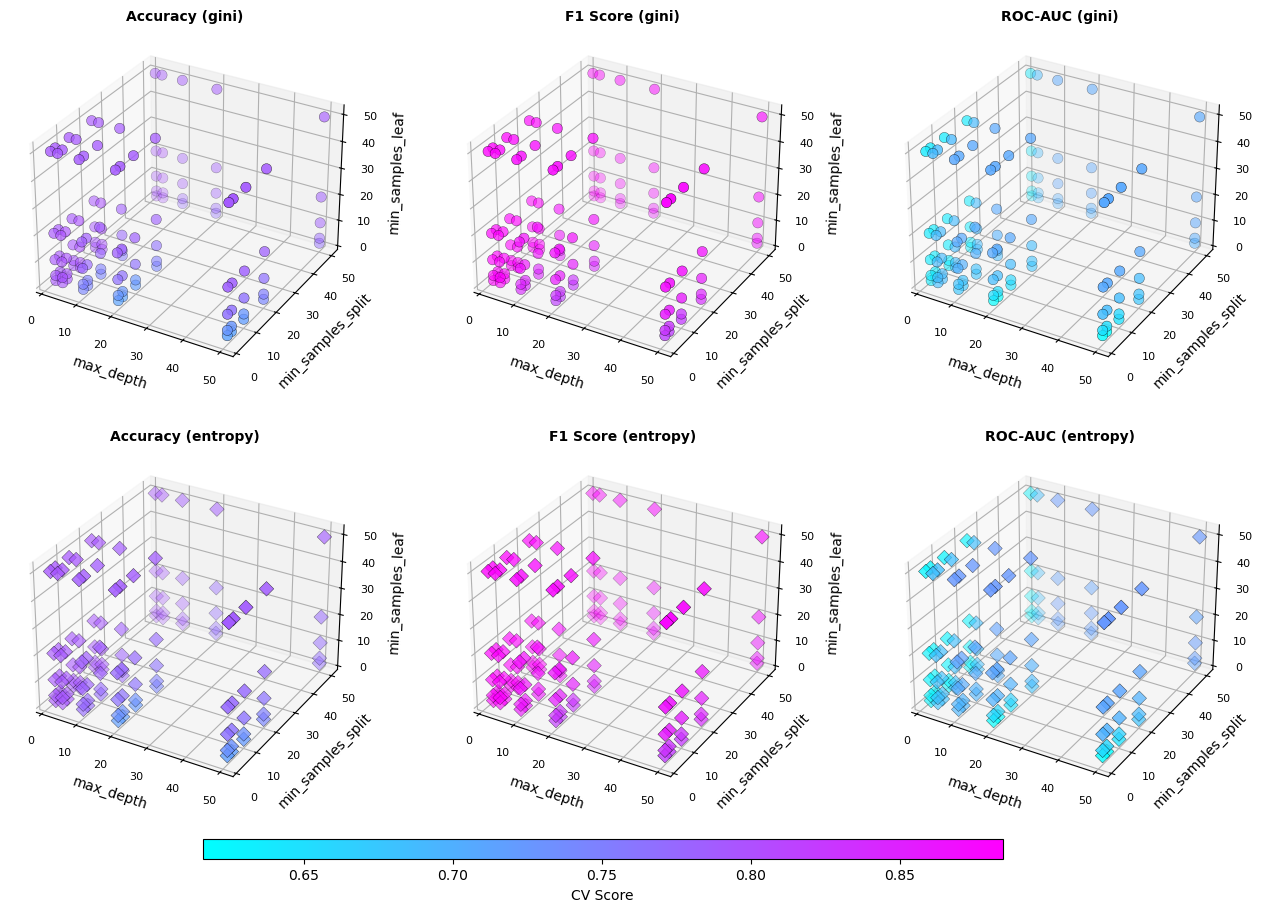

In [5]:
# Visualization: Decision Tree GridSearchCV Results (Gini & Entropy) 
metrics= {
    'Accuracy': 'mean_test_accuracy',
    'F1 Score': 'mean_test_f1',
    'ROC-AUC': 'mean_test_roc_auc'
}
criteria = ['gini', 'entropy']
shapes = {'gini': 'o', 'entropy': 'D'}

cmin = results[['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']].min().min()
cmax = results[['mean_test_accuracy', 'mean_test_f1', 'mean_test_roc_auc']].max().max()
norm = Normalize(vmin=cmin, vmax=cmax)

fig = plt.figure(figsize=(16, 10))
for i, crit in enumerate(criteria):
    subset = results[results['param_criterion'] == crit]
    x = subset['param_max_depth'].infer_objects(copy=False).fillna(50)
    y = subset['param_min_samples_split']
    z = subset['param_min_samples_leaf']

    for j, (label, metric) in enumerate(metrics.items()):
        ax = fig.add_subplot(2, 3, i*3 + j + 1, projection='3d')
        sc = ax.scatter(x, y, z, c=subset[metric], cmap='cool', norm=norm, s=55, edgecolor='k', linewidth=0.3, marker=shapes[crit]) # type: ignore
        ax.set_title(f"{label} ({crit})", fontsize=10, weight='semibold')
        ax.set_xlabel('max_depth')
        ax.set_ylabel('min_samples_split')
        ax.set_zlabel('min_samples_leaf')  # type: ignore
        ax.tick_params(labelsize=8)

sm = ScalarMappable(norm=norm, cmap='cool')
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.02]) # type: ignore
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label='CV Score')
plt.show()

In [6]:
# 3D Interactive Plot
fig = go.Figure()
for metric_name, metric_col in metrics.items():
  for crit in criteria:
    subset = results[results['param_criterion'] == crit]
    fig.add_trace(go.Scatter3d(
      x=subset['param_max_depth'].infer_objects(copy=False).fillna(50),
      y=subset['param_min_samples_split'],
      z=subset['param_min_samples_leaf'],
      mode='markers',
      marker=dict(
        size=6, color=subset[metric_col], colorscale='icefire',
        line=dict(width=0.5, color='black'), opacity=0.85,
        colorbar=dict(title="CV Score", thickness=15, len=0.7, x=1.02, y=0.4),
        cmin=cmin, cmax=cmax, symbol = 'circle' if crit == 'gini' else 'diamond'
      ),
      name=f"{metric_name} - {crit.capitalize()}",
      hovertemplate='<b>%{text}</b><extra></extra>',
      text=[f"Depth: {d}<br>Split: {s}<br>Leaf: {l}<br>{metric_name}: {v:.4f}" 
            for d, s, l, v in zip(subset['param_max_depth'], 
                                  subset['param_min_samples_split'],
                                  subset['param_min_samples_leaf'],
                                  subset[metric_col])]
    ))

fig.update_layout(
  template='plotly_white',
  scene=dict(
    xaxis_title='Max Depth', yaxis_title='Min Samples Split', zaxis_title='Min Samples Leaf',
    xaxis=dict(gridcolor='lightgray', showbackground=True),
    yaxis=dict(gridcolor='lightgray', showbackground=True),
    zaxis=dict(gridcolor='lightgray', showbackground=False),
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))
  ),
  width=800, height=600, margin=dict(l=2, r=0, b=0, t=5),
  showlegend=True,
  legend=dict(
    yanchor="top", y=0.95, xanchor="right", x=1.15,
    bgcolor="rgba(255,255,255,0.8)", bordercolor="gray", borderwidth=1
  )
)
fig.show()

**Insights:**

1. min_sample_split, there is a clear relation -> Scoring is decreased with increase in min_samples_split.
2. There is clear substitution effect between max_depth and min_sample_leaf. max_depth can be increased with increase in min_sampe_leaf maintaining the score.
3. There is no significant difference in scores between gini and entropy criteria for all the scoring criteria results.
4. Fit the best hyperparameters obtained from CV tuning for different scores to then narrow down the best hyperparameter.

**Notes:**

Fit the Best Hyperparameters in the testing dataset [CV2 - StratifiedKFold].

In [7]:
# Testing the Best Models on Test Set [CV2 - StratifiedKFold]
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
performance = []
for metric, info in best_params.items():
    params = info['params']
    cv_score = info['cv_score']
    model = DecisionTreeClassifier(**params, random_state=42)

    result = cross_validate(model, X_train, y_train, cv=cv_strategy, scoring=scoring, return_train_score=False)

    performance.append({
        'Score Criteria': metric,
        'CV2 Accuracy': result['test_accuracy'].mean(),
        'CV2 F1': result['test_f1'].mean(),
        'CV2 ROC-AUC': result['test_roc_auc'].mean(),
        'CV Score': cv_score,
        'Best Hyperparameters': params
    })

display(HTML("<b>CV2 Performance Comparison:</b>"))
perf_df = (
    pd.DataFrame(performance).sort_values('CV2 Accuracy', ascending=False).style
    .format({'CV2 Accuracy': '{:.3f}', 'CV2 F1': '{:.3f}', 'CV2 ROC-AUC': '{:.3f}', 'CV Score': '{:.3f}'})
    .background_gradient(subset=['CV2 Accuracy', 'CV2 F1', 'CV2 ROC-AUC'], cmap='YlGn')
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f7f7f7'), ('border-bottom', '2px solid #ccc'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '6px 8px'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#fbfbfb')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f1f8ff')]}
    ])
    .hide(axis='index')
)
display(perf_df)

Score Criteria,CV2 Accuracy,CV2 F1,CV2 ROC-AUC,CV Score,Best Hyperparameters
roc_auc,0.801,0.886,0.741,0.724,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 2}"
accuracy,0.799,0.886,0.697,0.797,"{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 2}"
f1,0.793,0.884,0.660,0.884,"{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2}"


**Insights:**

1. Best Hyperparameters obtained from roc_auc score criteria used for CV gives consistent scores for all the scoring tests.
2. The hyperparameters can be taken for fitting our final model, but keeping in mind that others give similar results and this cannot be generalised.
3. From visualisation and other insights above, we select roc_auc best hyperparameters and gini as criteria, given above visualisation insights too.
4. min_impurity_decrease hyperparameter is added to avoid high overfitting, unnecessary splits and maintain simple, generalised model. (very small value)

**Notes:**

Use the following hyperparameters based on tuning and other insights above for modelling the decision tree.
- Criterion: gini
- Max Depth: 10
- Min Sample in Leaf: 50
- Min Sampls for Split: 2
- Min Impurity Decrease needed for Split: 0.001

Random State for Replicability: 42

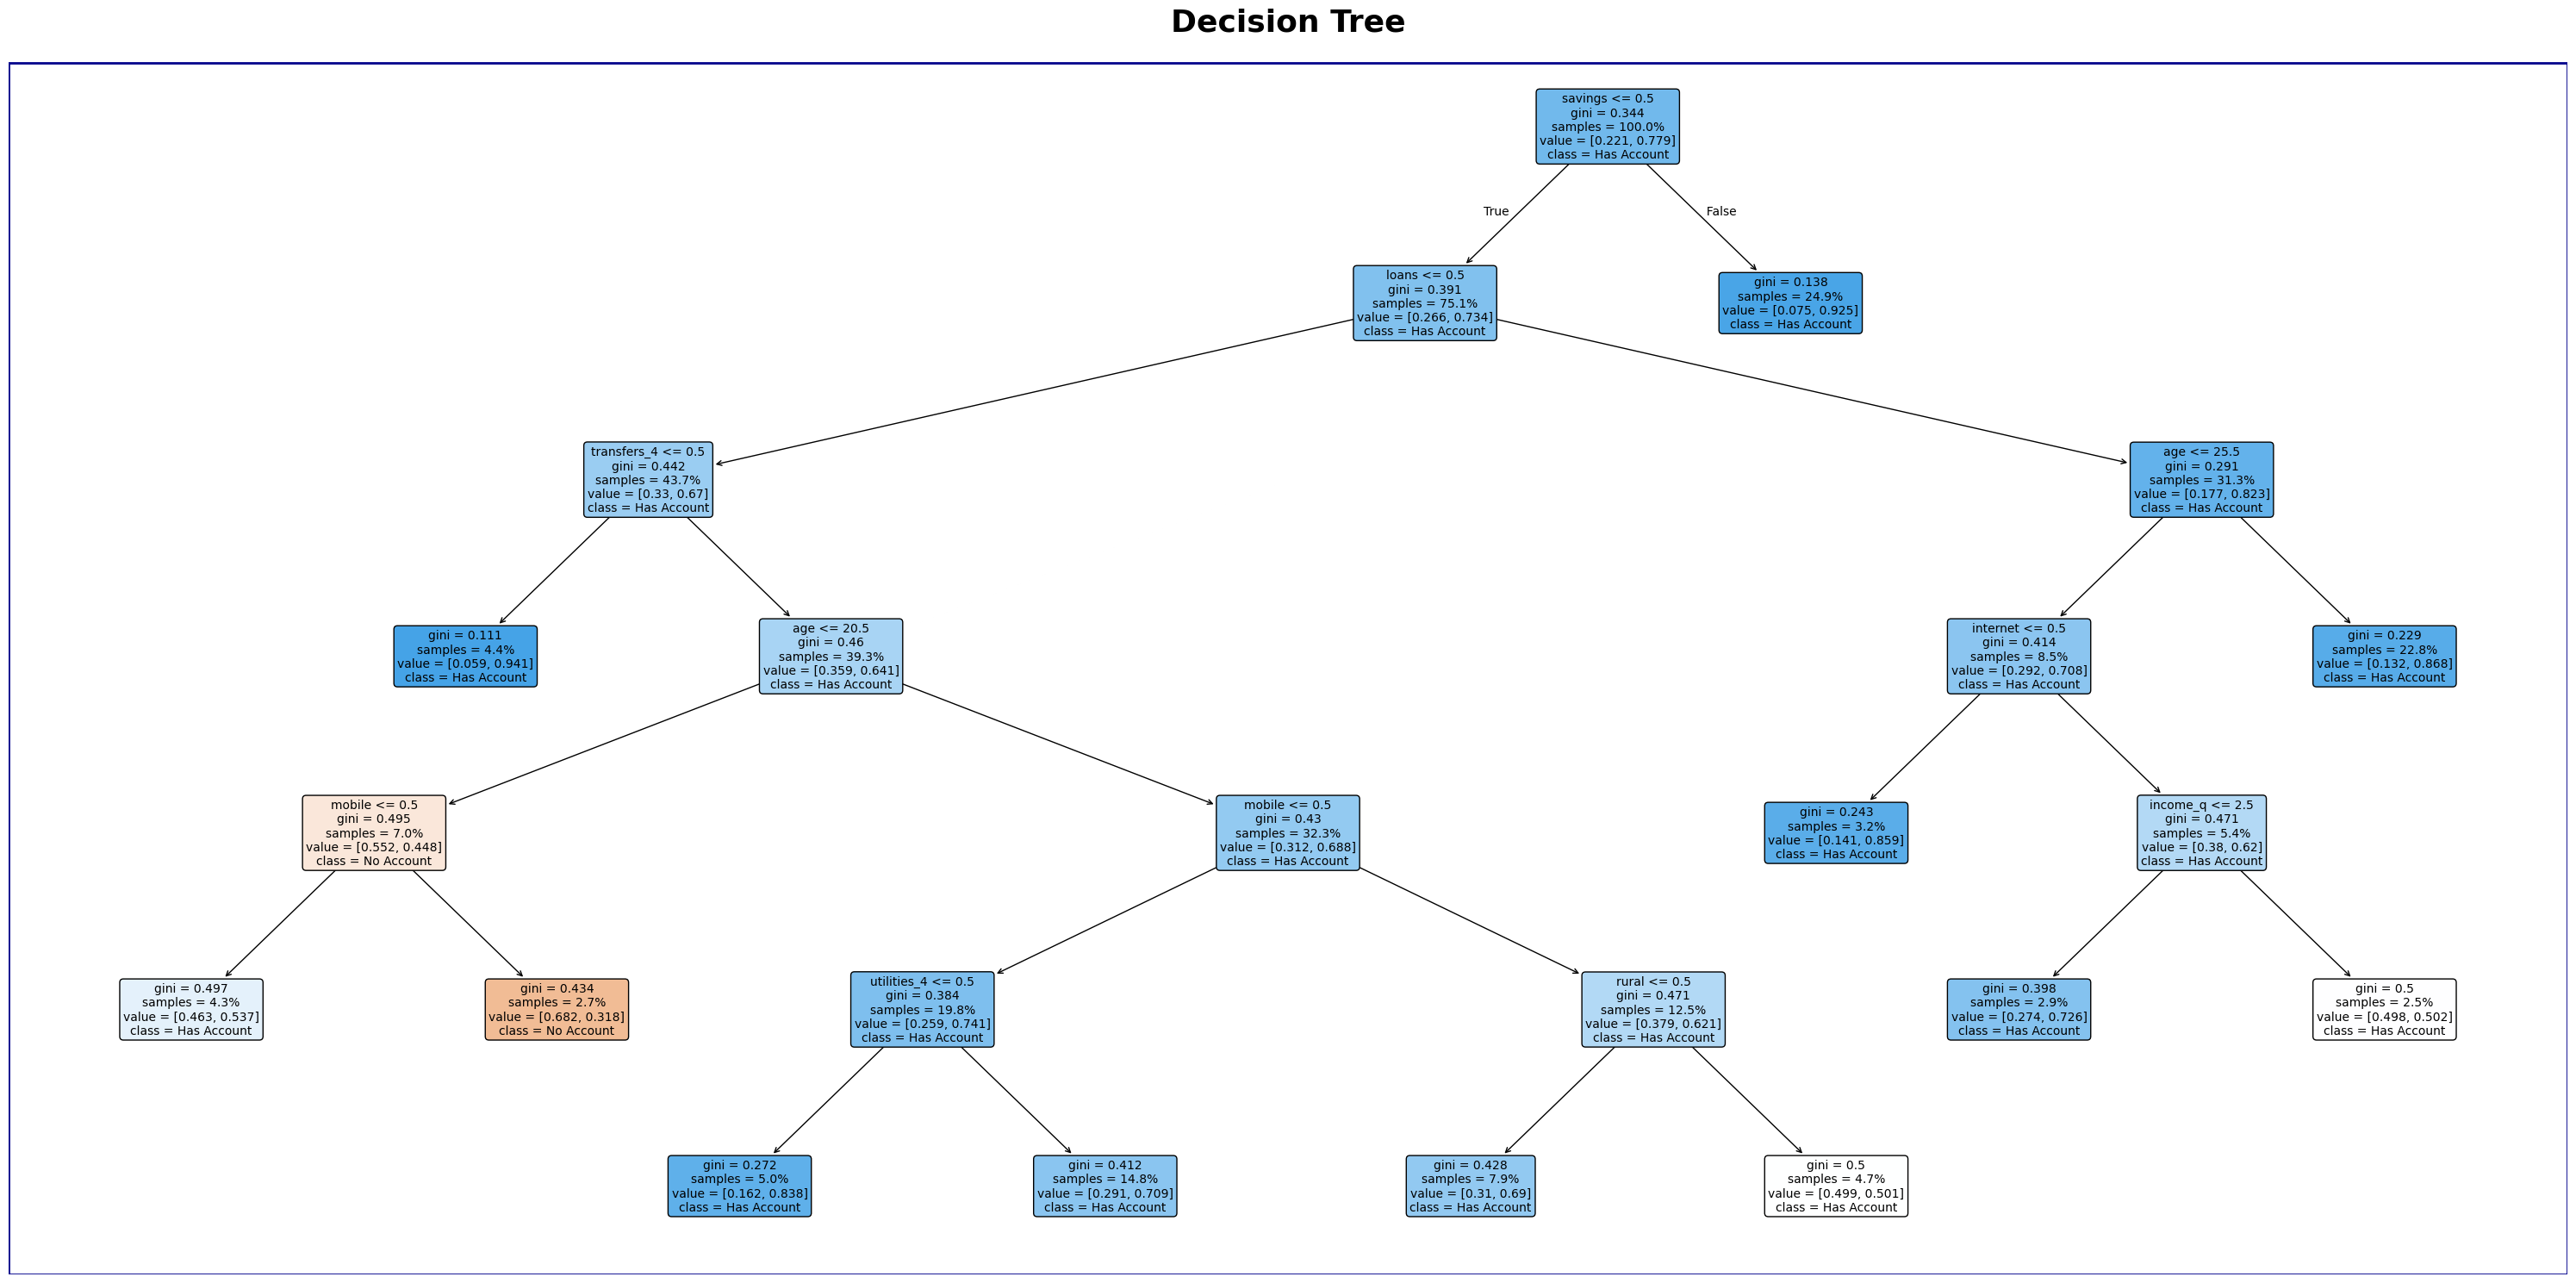

In [8]:
# Visualizing the Decision Tree
tree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=50, min_impurity_decrease=0.001, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train, sample_weight=weights_train)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title("Decision Tree", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {tree.score(X_train, y_train):.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {tree.score(X_test, y_test):.4f}
        </center>
    """
))

**Insights:**
1. Test and Train Score slightly improved from min_impurity_decrease.
2. Check for FP and FN to train the model according to policy implications(costs).

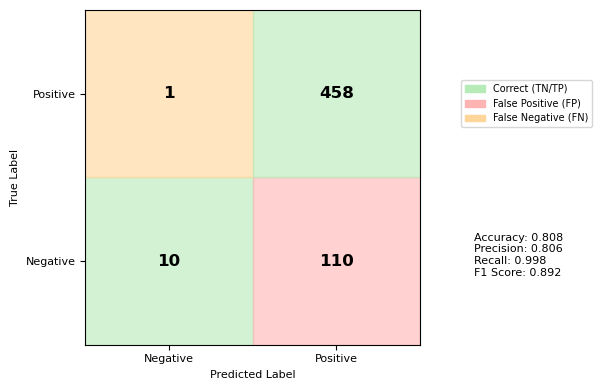

Model              TN     FP     FN     TP     Type I   Type II 
-----------------------------------------------------------------
Decision Tree      10     110    1      458    0.917    0.002   


In [9]:
# Confusion Matrix
y_pred = tree.predict(X_test)
metrics = (
    f'Accuracy: {accuracy_score(y_test, y_pred):.3f}\n'
    f'Precision: {precision_score(y_test, y_pred):.3f}\n'
    f'Recall: {recall_score(y_test, y_pred):.3f}\n'
    f'F1 Score: {f1_score(y_test, y_pred):.3f}\n'
)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
type_i_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
type_ii_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

cell_colors = np.array([
    ['#b6eab6', '#ffb3b3'],  # TN, FP
    ['#ffd699', '#b6eab6']   # FN, TP
])

fig, ax = plt.subplots(figsize=(8, 4))
for (row, col), val in np.ndenumerate(cm):
    ax.add_patch(mpatches.Rectangle((col, row), 1, 1, color=cell_colors[row, col], alpha=0.6))
    ax.text(col + 0.5, row + 0.5, str(val), va='center', ha='center', fontsize=12, fontweight='bold')

ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_yticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_xlabel('Predicted Label', fontsize=8)
ax.set_ylabel('True Label', fontsize=8)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.grid(False)
ax.set_aspect('equal')

ax.text(2.32, 0.5, metrics, fontsize=8, va='center', ha='left')

legend_patches = [
    mpatches.Patch(color='#b6eab6', label='Correct (TN/TP)'),
    mpatches.Patch(color='#ffb3b3', label='False Positive (FP)'),
    mpatches.Patch(color='#ffd699', label='False Negative (FN)')
]
fig.legend(handles=legend_patches, bbox_to_anchor=(0.93, 0.8), ncol=1, fontsize=7, frameon=True)

plt.tight_layout()
plt.show()

print(f"{'Model':<18} {'TN':<6} {'FP':<6} {'FN':<6} {'TP':<6} {'Type I':<8} {'Type II':<8}")
print("-" * 65)
print(f"{'Decision Tree':<18} {tn:<6} {fp:<6} {fn:<6} {tp:<6} {type_i_rate:<8.3f} {type_ii_rate:<8.3f}")


**Insights:**

1. Type I Error (FP) is high.
2. Check if ROC curves are robust for threshold optimisation.

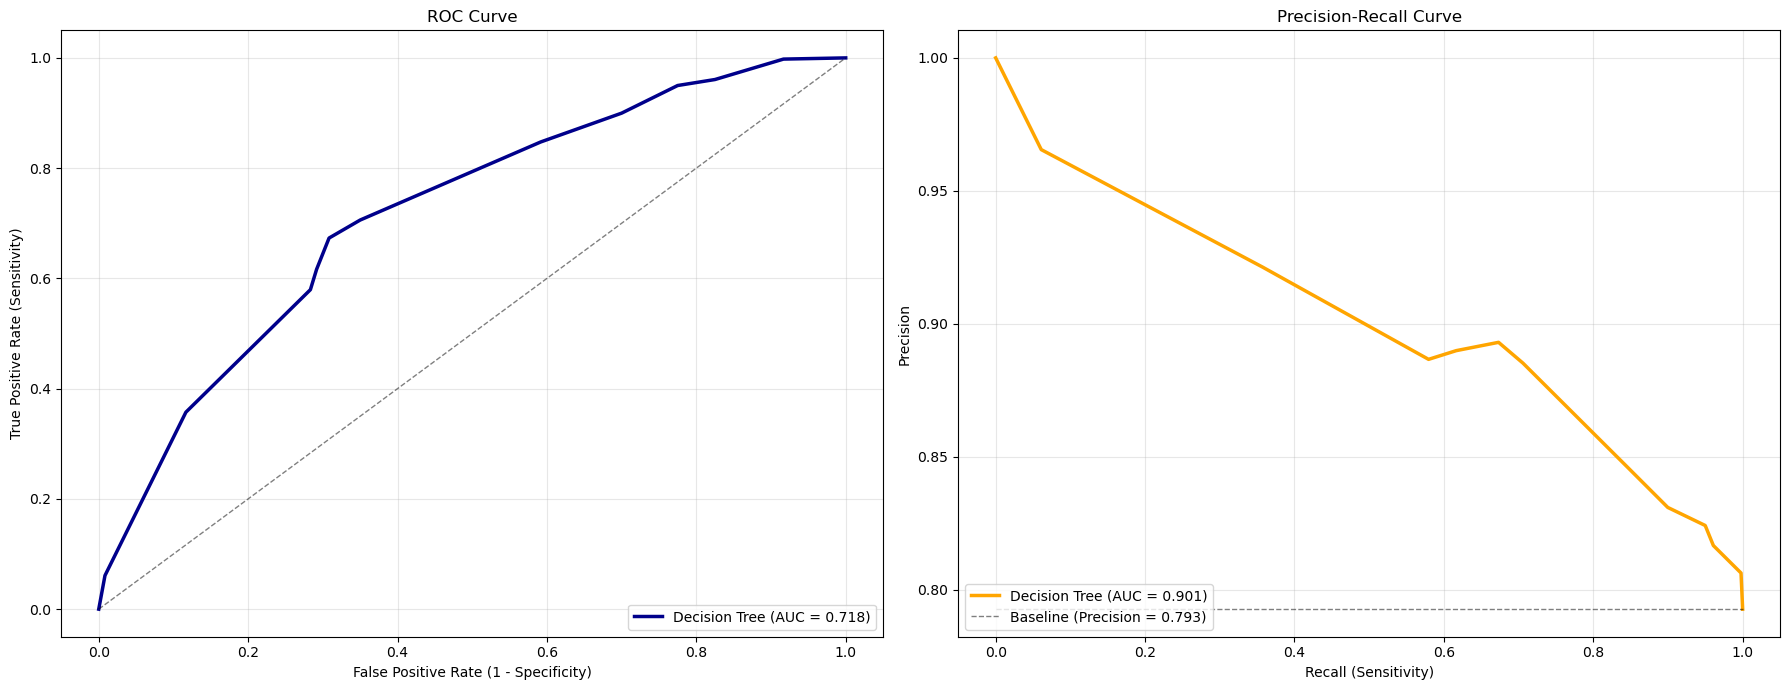

In [10]:
# ROC and Precision-Recall Curves
y_prob = tree.predict_proba(X_test)[:, 1] # type: ignore

plt.figure(figsize=(18, 7))
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkblue', lw=2.5,
         label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
baseline = y_test.mean()

plt.plot(recall, precision, color='orange', lw=2.5,
         label=f'Decision Tree (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [baseline, baseline], 'k--', lw=1, alpha=0.5,
         label=f'Baseline (Precision = {baseline:.3f})')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

1. ROC Score is high and the curve does not comprimise true positive rate much on decreasing false positive rate.
2. Set Cost Scenerios to minimize FP and FN.


Cost Scenarios:
- Balanced Costs: Type I Cost = 1, Type II Cost = 1
- High FN Cost: Type I Cost = 1, Type II Cost = 5
- High FP Cost: Type I Cost = 2, Type II Cost = 1


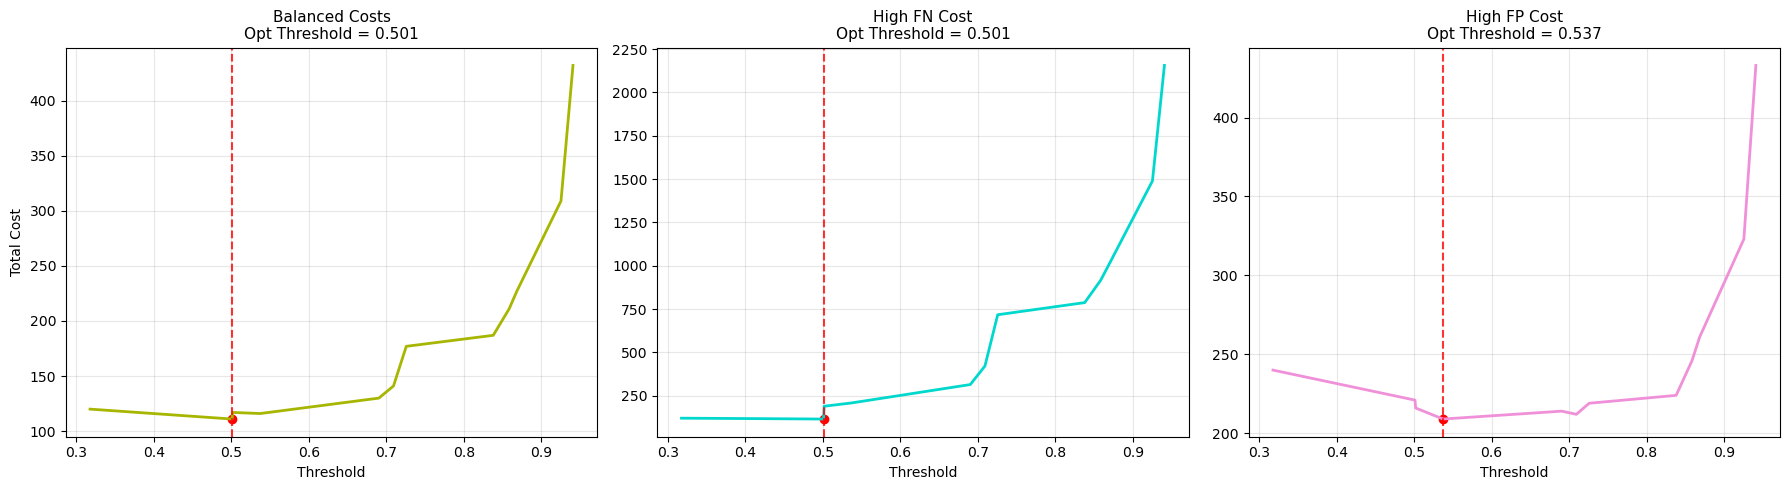


Threshold Optimization Summary:
Scenario                            │ Opt_Thr  │ Total_Cost │ Acc     │ Prec     │ Rec     │ F1      │ FP  │ FN 
Balanced Costs                      │ 0.501    │ 111        │ 0.808   │ 0.806    │ 0.998   │ 0.892   │ 110 │ 1  
High FN Cost                        │ 0.501    │ 115        │ 0.808   │ 0.806    │ 0.998   │ 0.892   │ 110 │ 1  
High FP Cost                        │ 0.537    │ 209        │ 0.8     │ 0.824    │ 0.95    │ 0.883   │ 93  │ 23 


In [11]:
# Threshold Optimization for Decision Tree (ROC-PR AUC) with Cost Scenarios
cost_scenarios = {
    'Balanced Costs': {'cost_fp': 1, 'cost_fn': 1},
    'High FN Cost':   {'cost_fp': 1, 'cost_fn': 5},
    'High FP Cost':   {'cost_fp': 2, 'cost_fn': 1}
}
print("\nCost Scenarios:")
for scenario, costs in cost_scenarios.items():
    print(f"- {scenario}: Type I Cost = {costs['cost_fp']}, Type II Cost = {costs['cost_fn']}")

colors = ["#a7b600", "#00d8cd", "#ef90d9"]
results = []

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (scenario, costs) in enumerate(cost_scenarios.items()):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    total_costs = []

    for thr in thresholds:
        preds = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        total_costs.append(fp * costs['cost_fp'] + fn * costs['cost_fn'])
    total_costs = np.array(total_costs)
    opt_idx = np.argmin(total_costs)
    opt_thr, opt_cost = thresholds[opt_idx], total_costs[opt_idx]

    preds_opt = (y_prob >= opt_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_opt).ravel()
    acc = accuracy_score(y_test, preds_opt)
    prec = precision_score(y_test, preds_opt)
    rec = recall_score(y_test, preds_opt)
    f1 = f1_score(y_test, preds_opt)

    ax = axes[i]
    ax.plot(thresholds, total_costs, color=colors[i], lw=2)
    ax.axvline(opt_thr, color='red', ls='--', alpha=0.8)
    ax.scatter(opt_thr, opt_cost, color='red')
    ax.set_title(f"{scenario}\nOpt Threshold = {opt_thr:.3f}", fontsize=11)
    ax.set_xlabel('Threshold')
    if i == 0: ax.set_ylabel('Total Cost')
    ax.grid(alpha=0.3)

    results.append({
        'Scenario': scenario, 'Opt_Threshold': round(opt_thr, 3), 'Total_Cost': round(opt_cost, 2),
        'Accuracy': round(acc, 3), 'Precision': round(prec, 3),  # type: ignore
        'Recall': round(rec, 3), 'F1_Score': round(f1, 3), # type: ignore
        'FP': fp, 'FN': fn
    })
plt.tight_layout()
plt.show()

results_df = pd.DataFrame(results)
print("\nThreshold Optimization Summary:")
print("=" * 125)
print(f"{'Scenario':<35} │ {'Opt_Thr':<8} │ {'Total_Cost':<10} │ {'Acc':<7} │ {'Prec':<8} │ {'Rec':<7} │ {'F1':<7} │ {'FP':<3} │ {'FN':<3}")
print("=" * 125)
for _, r in results_df.iterrows():
    print(f"{r['Scenario']:<35} │ {r['Opt_Threshold']:<8} │ {r['Total_Cost']:<10} │ "
          f"{r['Accuracy']:<7} │ {r['Precision']:<8} │ {r['Recall']:<7} │ {r['F1_Score']:<7} │ "
          f"{r['FP']:<3} │ {r['FN']:<3}")
print("=" * 125)

**Insights:**

1. False Negatives were initially low, hence no change in optimal threshold of penalty on FN.
2. FP was very high initially, hence accuracy and FN are very sensitive to FP Costs.
3. Set Costs such that it doesnt comprimise accuracy much and keeps the FP and FN relatively same.

,FP_Cost,Opt_Threshold,FP,FN,Accuracy,Precision,Recall,F1_Score
0,1.000000,0.501,110,1,0.808290,0.806338,0.997821,0.891918
1,1.081633,0.501,110,1,0.808290,0.806338,0.997821,0.891918
2,1.163265,0.501,110,1,0.808290,0.806338,0.997821,0.891918
3,1.244898,0.501,110,1,0.808290,0.806338,0.997821,0.891918
4,1.326531,0.537,93,23,0.799655,0.824197,0.949891,0.882591
5,1.408163,0.537,93,23,0.799655,0.824197,0.949891,0.882591
6,1.489796,0.537,93,23,0.799655,0.824197,0.949891,0.882591
7,1.571429,0.537,93,23,0.799655,0.824197,0.949891,0.882591
8,1.653061,0.537,93,23,0.799655,0.824197,0.949891,0.882591
9,1.734694,0.537,93,23,0.799655,0.824197,0.949891,0.882591


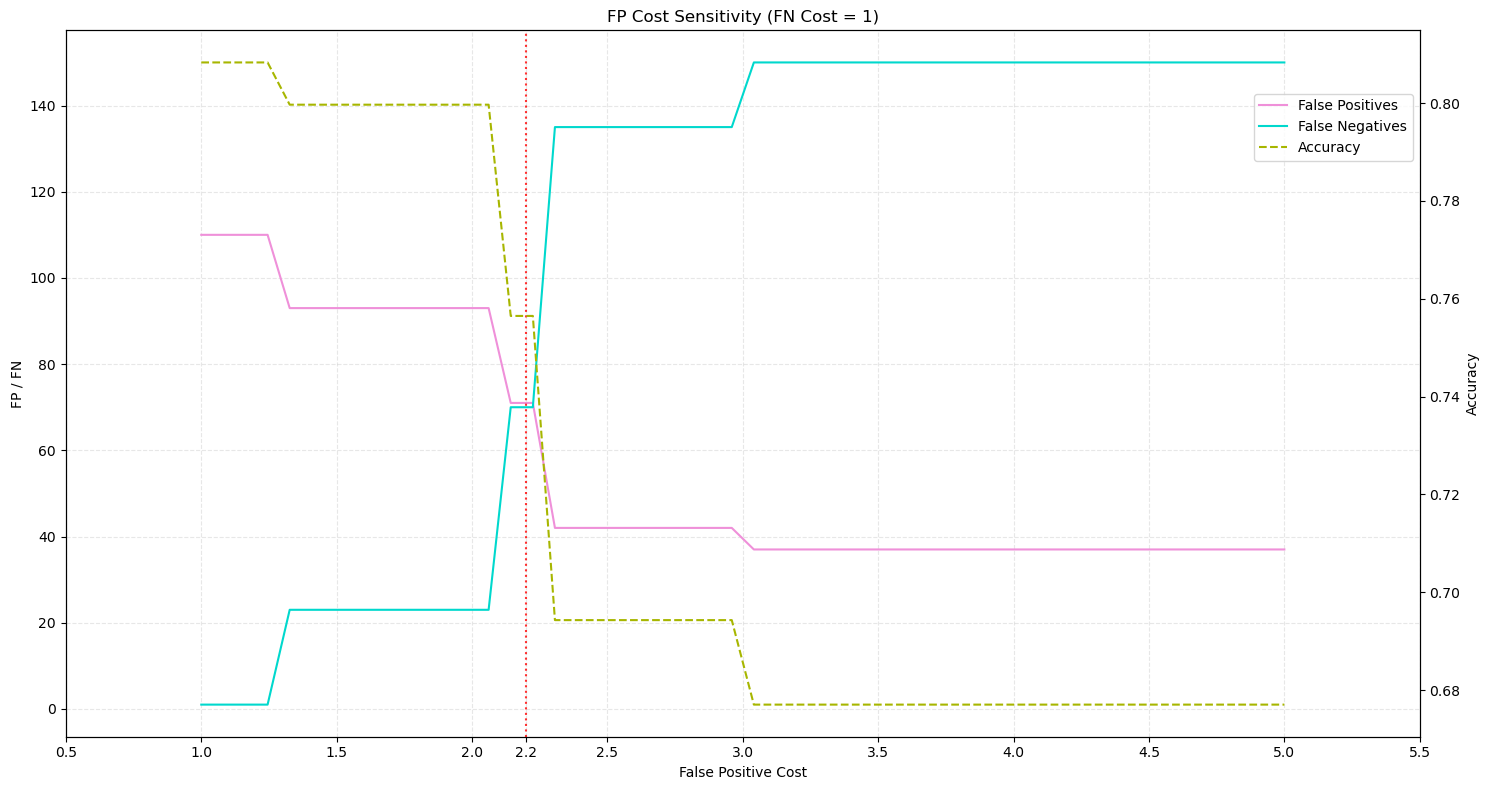

In [12]:
# FP Cost Sensitivity Analysis (FN Cost = 1)
cost_fn = 1
fp_cost_range = np.linspace(1, 5, 50)
results = []

for cost_fp in fp_cost_range:
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    total_costs = []

    for thr in thresholds:
        preds = (y_prob >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        total_costs.append(fp * cost_fp + fn * cost_fn)

    total_costs = np.array(total_costs)
    opt_idx = np.argmin(total_costs)
    opt_thr = thresholds[opt_idx]

    preds_opt = (y_prob >= opt_thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds_opt).ravel()
    acc = accuracy_score(y_test, preds_opt)
    prec = precision_score(y_test, preds_opt)
    rec = recall_score(y_test, preds_opt)
    f1 = f1_score(y_test, preds_opt)

    results.append({
        'FP_Cost': cost_fp,
        'Opt_Threshold': round(opt_thr, 3),
        'FP': fp,
        'FN': fn,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1_Score': f1
    })
results_df = pd.DataFrame(results)
display(HTML("<b>FP Cost Sensitivity (FN Cost = 1):</b>"))
display(results_df)

fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()
ax1.plot(results_df['FP_Cost'], results_df['FP'], color="#ef90d9", label='False Positives')
ax1.plot(results_df['FP_Cost'], results_df['FN'], color="#00d8cd", label='False Negatives')
ax2.plot(results_df['FP_Cost'], results_df['Accuracy'], color="#a7b600", linestyle='--', label='Accuracy')
ax1.axvline(x=2.20, color='red', linestyle=':', alpha=0.8)
ax1.set_xticks(list(ax1.get_xticks()) + [2.20])
ax1.set_xlabel("False Positive Cost")
ax1.set_ylabel("FP / FN")
ax2.set_ylabel("Accuracy")
ax1.grid(alpha=0.3, linestyle='--')

plt.title("FP Cost Sensitivity (FN Cost = 1)")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', bbox_to_anchor=(1, 0.92))

plt.tight_layout()
plt.show()

**Insights:**

1. Accuracy Rapidly falls below 0.7 after FP Cost 2.4. 
2. FN is increasing at a higher rate than decrease in FP.
3. Between 2.1-2.2 there is nice balance of FP and FN with accuracy also not being comprimisied.
4. Optimal Threshold is 0.709 at this FP Cost.

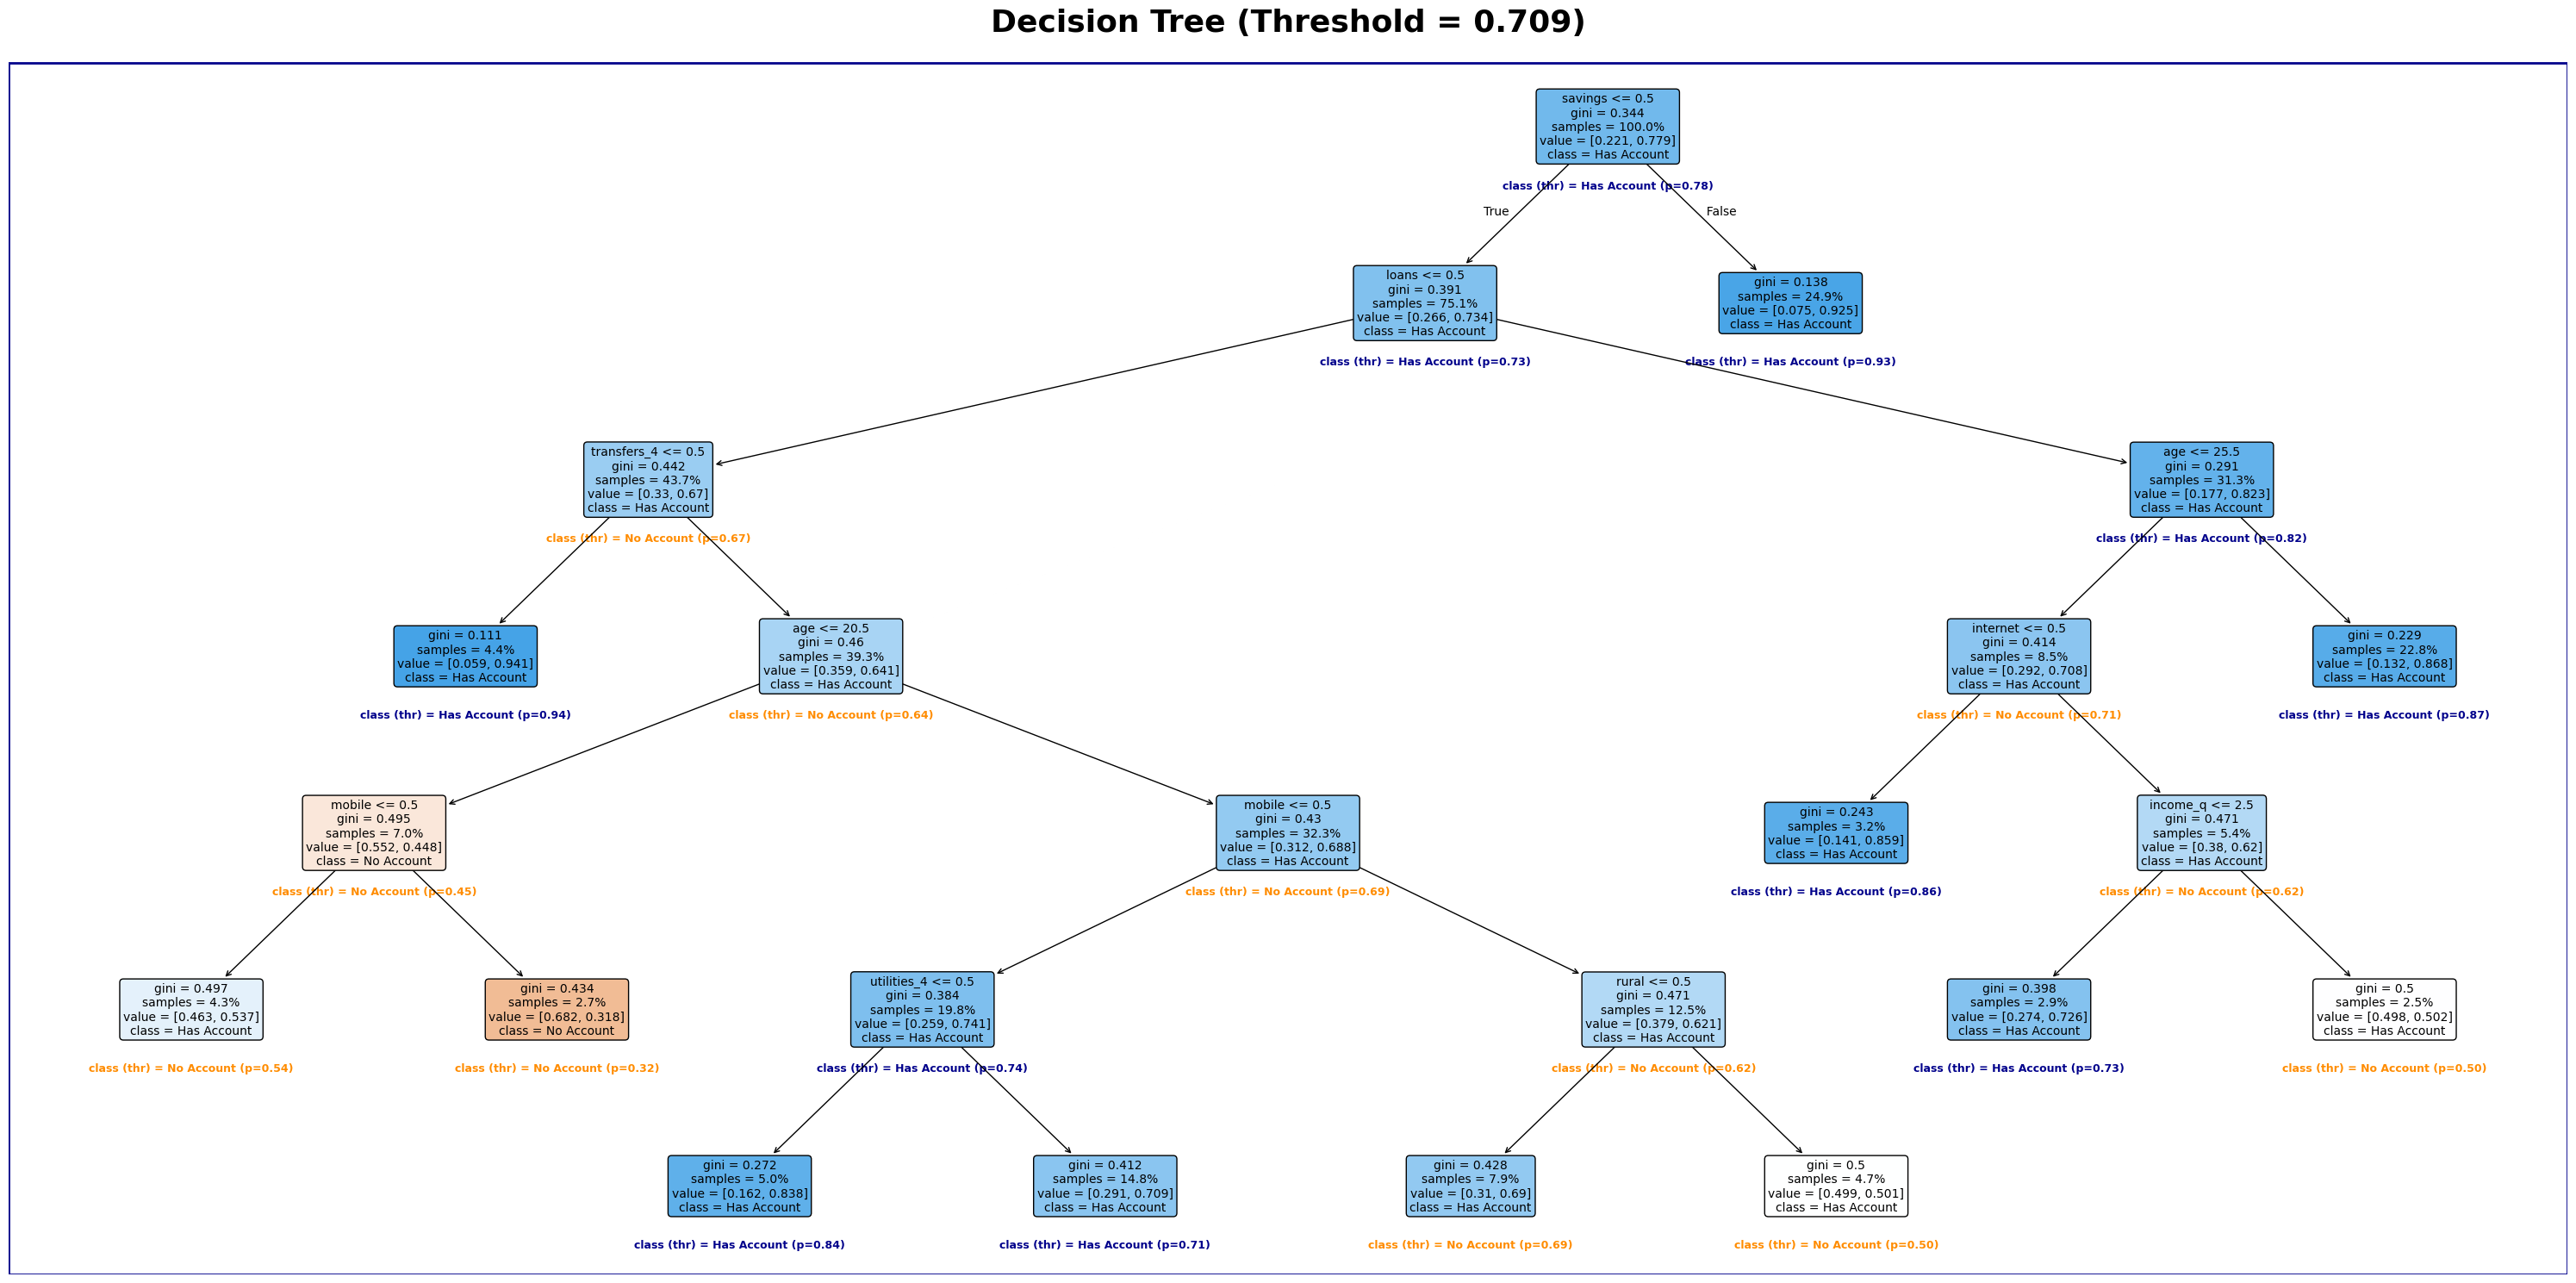

In [13]:
# Visualising the Decision Tree with Cost Adjusted Threshold
threshold = 0.709

y_train_prob = tree.predict_proba(X_train)[:, 1] # type: ignore
y_test_prob = tree.predict_proba(X_test)[:, 1] # type: ignore
y_train_pred = (y_train_prob >= threshold).astype(int)
y_test_pred = (y_test_prob >= threshold).astype(int)
train_score = accuracy_score(y_train, y_train_pred)
test_score = accuracy_score(y_test, y_test_pred)

values = tree.tree_.value.squeeze()
if values.ndim == 1:
    values = values.reshape(-1, 2)
node_probs = values[:, 1] / values.sum(axis=1)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title(f"Decision Tree (Threshold = {threshold})", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

value_texts = [t for t in ax.texts if 'value' in t.get_text()]
for i, txt in enumerate(value_texts):
    if i >= len(node_probs):
        break
    prob = node_probs[i]
    cls = 'Has Account' if prob >= threshold else 'No Account'
    color = 'darkblue' if cls == 'Has Account' else 'darkorange'
    x, y = txt.get_position()
    ax.text(
        x, y - 0.05,
        f'class (thr) = {cls} (p={prob:.2f})',
        ha='center',
        fontsize=9,
        color=color,
        weight='semibold'
    )
plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {train_score:.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {test_score:.4f}
        </center>
    """
))

**Insights:**

1. Tree remains the same, prediction of class differ due to threshold.
2. We see a lot more of no-account predictions due to the costs of FP.
3. Accuracy scores have fallen down as expected but is still a good score.
3. Compare its performance with initial balancd model to check if it is as desired.

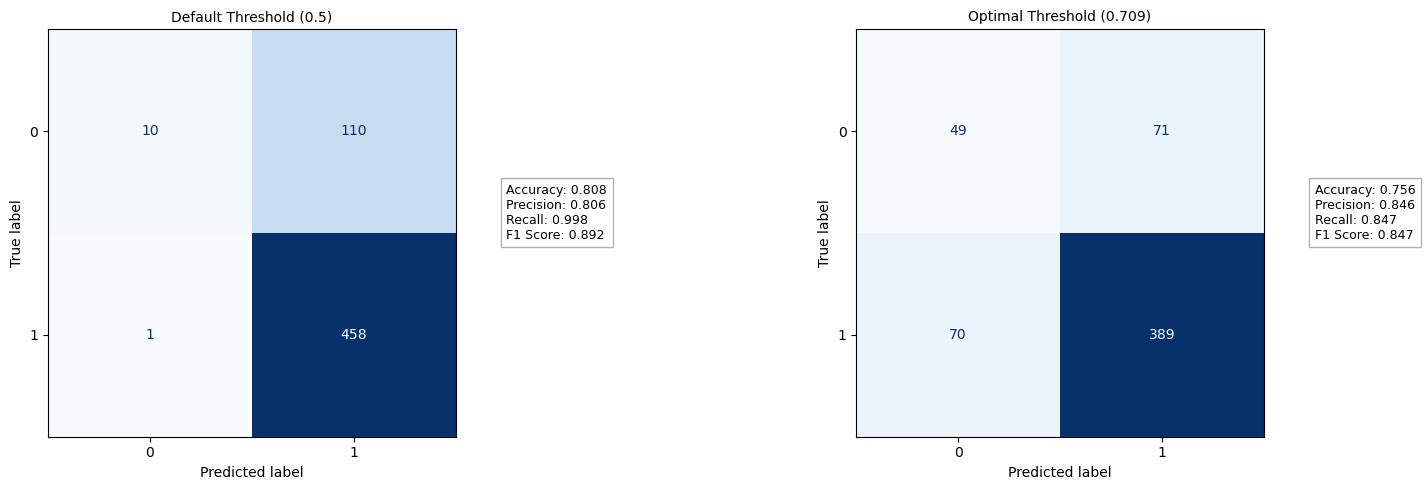

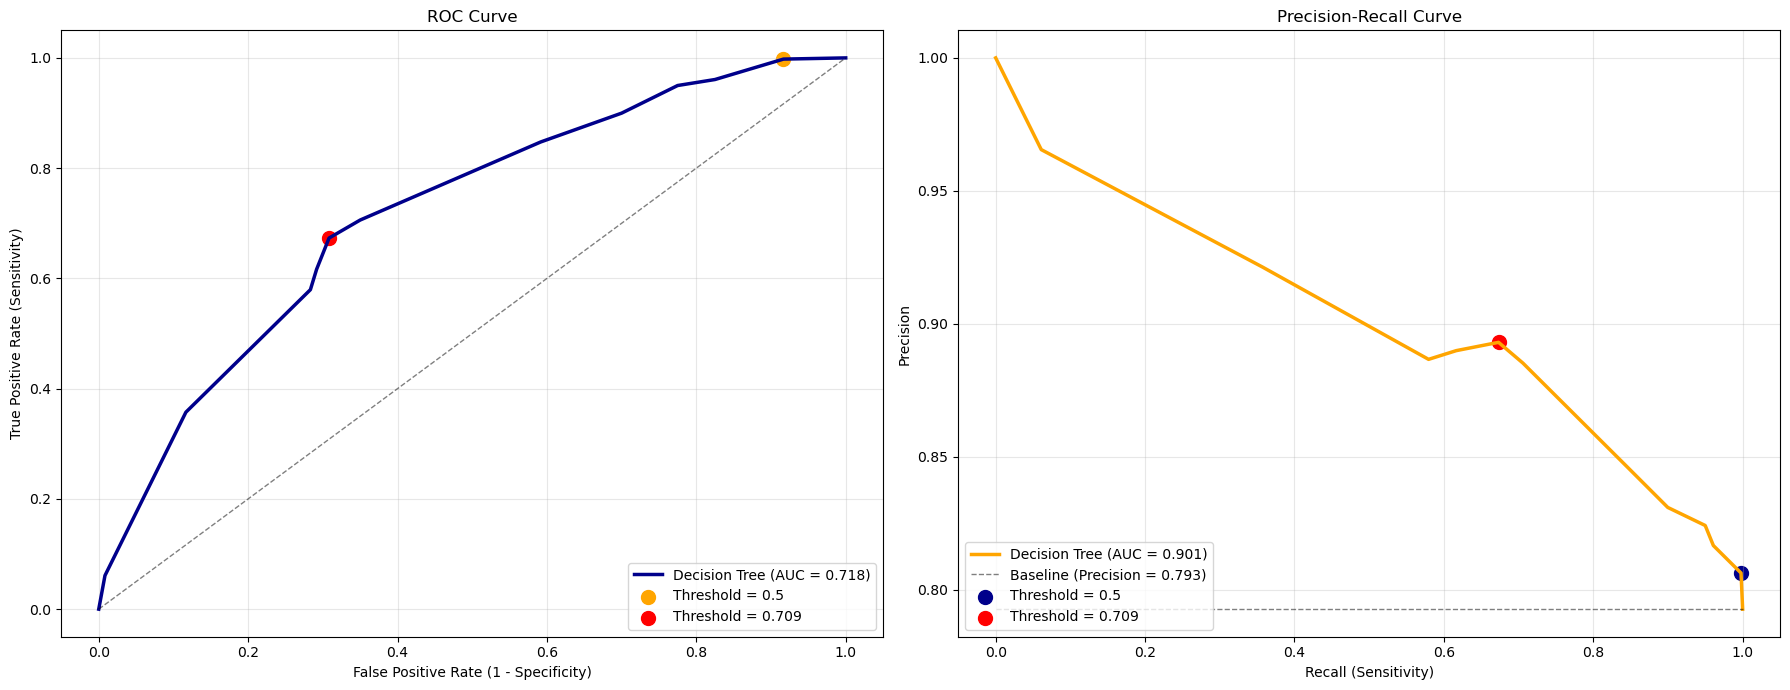

In [14]:
# Model Performance at Adjusted Threshold
y_prob = tree.predict_proba(X_test)[:, 1] # type: ignore

y_pred_default = (y_prob >= 0.5).astype(int)
y_pred_opt = (y_prob >= threshold).astype(int)
fig, axes = plt.subplots(1, 2, figsize=(17, 5))
titles = ['Default Threshold (0.5)', f'Optimal Threshold ({threshold})']
for ax, preds, title in zip(axes, [y_pred_default, y_pred_opt], titles):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    metrics = (
    f'Accuracy: {accuracy_score(y_test, preds):.3f}\n'
    f'Precision: {precision_score(y_test, preds):.3f}\n'
    f'Recall: {recall_score(y_test, preds):.3f}\n'
    f'F1 Score: {f1_score(y_test, preds):.3f}'
    )
    ax.text(1.75, 0.4, metrics, fontsize=9, va='center', ha='left', bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))
    ax.set_title(title, fontsize=10, weight='normal')   
plt.tight_layout()
plt.show()

fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
baseline = y_test.mean()

def find_nearest_idx(array, value):
    return np.argmin(np.abs(array - value))
roc_idx_default = find_nearest_idx(roc_thresholds, 0.5)
roc_idx_opt = find_nearest_idx(roc_thresholds, 0.838)
pr_idx_default = find_nearest_idx(pr_thresholds, 0.5)
pr_idx_opt = find_nearest_idx(pr_thresholds, 0.838)

plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkblue', lw=2.5,
         label=f'Decision Tree (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
plt.scatter(fpr[roc_idx_default], tpr[roc_idx_default],
            color='orange', s=100, label='Threshold = 0.5')
plt.scatter(fpr[roc_idx_opt], tpr[roc_idx_opt],
            color='red', s=100, label=f'Threshold = {threshold}')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='orange', lw=2.5,
         label=f'Decision Tree (AUC = {pr_auc:.3f})')
plt.plot([0, 1], [baseline, baseline], 'k--', lw=1, alpha=0.5,
         label=f'Baseline (Precision = {baseline:.3f})')
plt.scatter(recall[pr_idx_default], precision[pr_idx_default],
            color='darkblue', s=100, label='Threshold = 0.5')
plt.scatter(recall[pr_idx_opt], precision[pr_idx_opt],
            color='red', s=100, label=f'Threshold = {threshold}')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Insights:**

1. This threshold has balanced FP and FN fairly well without comprimising the metrics much.
2. Recall has been decreased until the point where precision increases, as seen in PR curve.
3. In ROC Curve we can see the threshold shifts until the point after which desent is significantly increased for TPR.

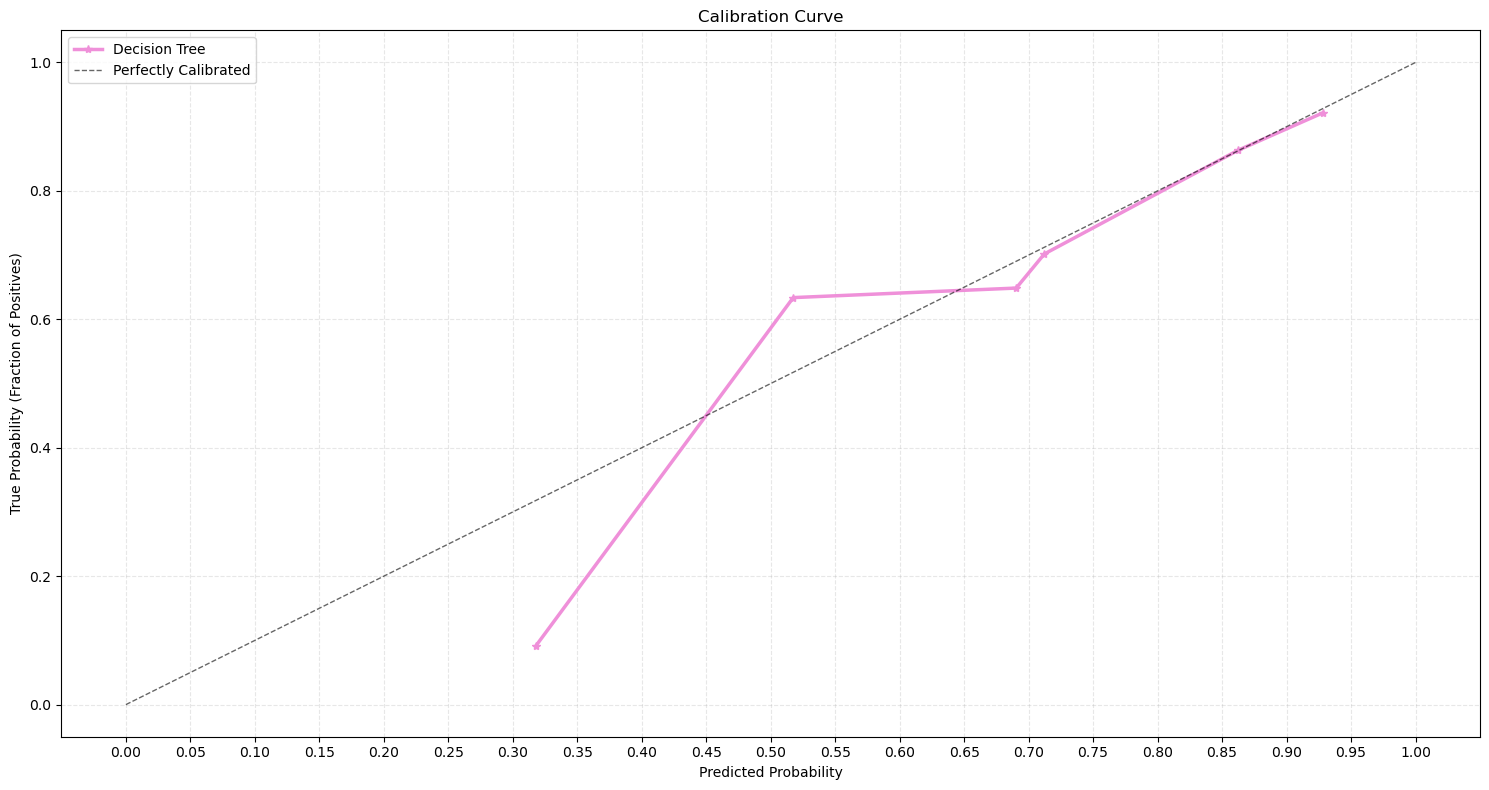

In [15]:
# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Plot Calibration Curve
plt.figure(figsize=(15, 8))
plt.plot(prob_pred, prob_true, marker='*', color='#ef90d9', lw=2.5, label='Decision Tree')
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.6, label='Perfectly Calibrated')

plt.xticks(np.arange(0.0, 1.05, 0.05))
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability (Fraction of Positives)')
plt.title('Calibration Curve')
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Insights:**

1. Decision Tree is well calibrated at high probabilities.
2. It overestimates at lower predicted probabilities.
3. In the mid range of predicted probabilites, it is slightly cautious, but at rest in general it slightly is overconfident.

Fitting 15 folds for each of 250 candidates, totalling 3750 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



Score Criteria,Test Accuracy,Test F1,Test ROC-AUC,CV Score,Best Hyperparameters
roc_auc,0.803,0.887,0.711,0.718,"{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 2}"
f1,0.793,0.884,0.634,0.884,"{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2}"
accuracy,0.784,0.874,0.684,0.797,"{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 20, 'min_samples_split': 2}"


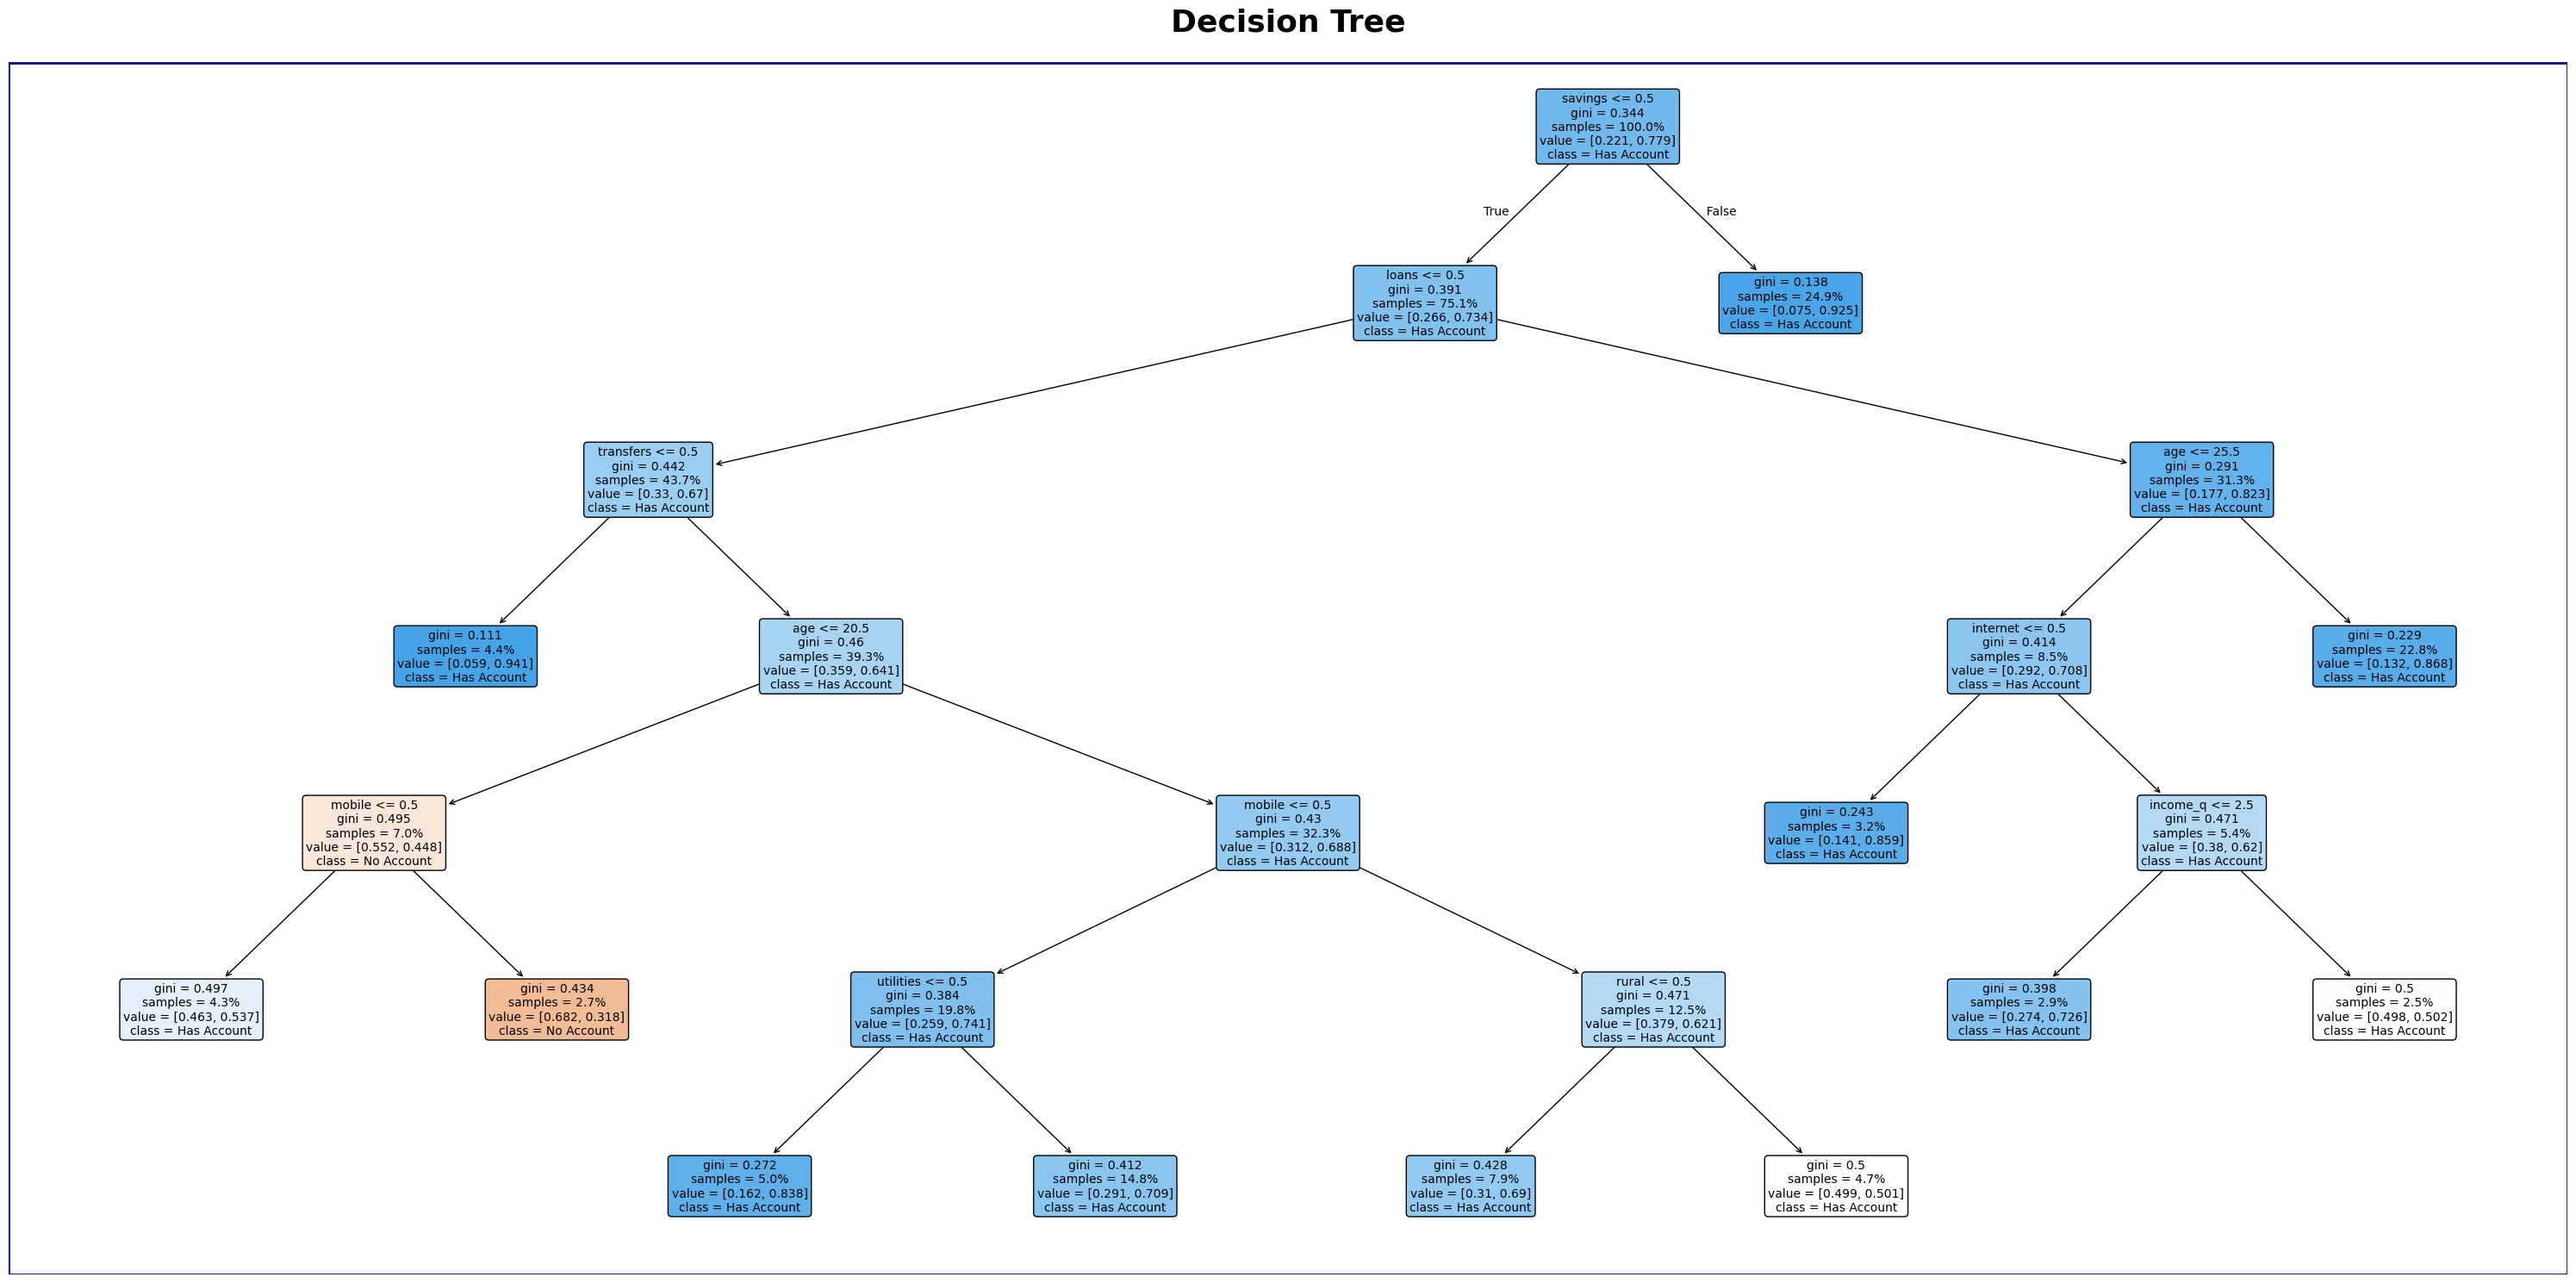

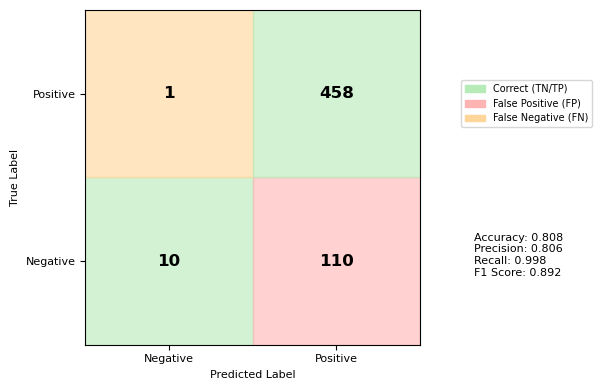

Model              TN     FP     FN     TP     Type I   Type II 
-----------------------------------------------------------------
Decision Tree      10     110    1      458    0.917    0.002   


In [16]:
# Model using the other Dataset
df = pd.read_csv('../Data/DT_2.csv')

# Train Test Split
y = df['account']
X = df.drop(columns=['account','wgt'])
weights = df['wgt']

X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
        X, y, weights, test_size=0.2, random_state=42, stratify=y
    )

# Decision Tree Hyperparameter Tuning with Multiple Scoring Metrics using GridSearchCV
tree = DecisionTreeClassifier(random_state=42)
param_grid = {
    'max_depth': [2, 4, 10, 20, None],
    'min_samples_split': [2, 4, 10, 20, 50],
    'min_samples_leaf': [2, 4, 10, 20, 50],
    'criterion': ['gini', 'entropy']
}
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']

grid = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    scoring=scoring,
    refit=False,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train, sample_weight=weights_train)

results = pd.DataFrame(grid.cv_results_)
best_params = {}
for metric in scoring:
    best_params[metric] = {
        'params': results.loc[results[f'rank_test_{metric}'].idxmin(), 'params'],
        'cv_score': results.loc[results[f'rank_test_{metric}'].idxmin(), f'mean_test_{metric}']
    }

# Evaluate Best Models
performance = []
for metric, info in best_params.items():
    params = info['params']
    cv_score = info['cv_score']
    model = DecisionTreeClassifier(**params, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] # type: ignore

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    performance.append({
        'Score Criteria': metric,
        'Test Accuracy': acc,
        'Test F1': f1,
        'Test ROC-AUC': roc,
        'CV Score': cv_score,
        'Best Hyperparameters': params
    })
perf_df = (
    pd.DataFrame(performance).sort_values('Test Accuracy', ascending=False).style
    .format({'Test Accuracy': '{:.3f}', 'Test F1': '{:.3f}', 'Test ROC-AUC': '{:.3f}', 'CV Score': '{:.3f}'})
    .background_gradient(subset=['Test Accuracy', 'Test F1', 'Test ROC-AUC'], cmap='YlGn')
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#f7f7f7'), ('border-bottom', '2px solid #ccc'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '6px 8px'), ('text-align', 'center')]},
        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#fbfbfb')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f1f8ff')]}
    ])
    .hide(axis='index')
)
display(perf_df)

# Visualizing the Decision Tree
tree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=50, min_impurity_decrease=0.001, min_samples_split=2, random_state=42)
tree.fit(X_train, y_train, sample_weight=weights_train)

fig, ax = plt.subplots(figsize=(30, 15))
plot_tree(
    tree,
    feature_names=list(X.columns),
    class_names=['No Account', 'Has Account'],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
    ax=ax
)
plt.title("Decision Tree", fontsize=26, weight='bold')
rect = mpatches.Rectangle((0, 0), 1, 0.98, transform=ax.transAxes, fill=False, edgecolor='darkblue', linewidth=2)
ax.add_patch(rect)

plt.tight_layout()
plt.show()

display(HTML(
    f"""<center>
        <b>Tree depth:</b> {tree.get_depth()} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Train Score:</b> {tree.score(X_train, y_train):.4f} &nbsp;&nbsp;|&nbsp;&nbsp;
        <b>Test Score:</b> {tree.score(X_test, y_test):.4f}
        </center>
    """
))

# Confusion Matrix
y_pred = tree.predict(X_test)
metrics = (
    f'Accuracy: {accuracy_score(y_test, y_pred):.3f}\n'
    f'Precision: {precision_score(y_test, y_pred):.3f}\n'
    f'Recall: {recall_score(y_test, y_pred):.3f}\n'
    f'F1 Score: {f1_score(y_test, y_pred):.3f}\n'
)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
type_i_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
type_ii_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

cell_colors = np.array([
    ['#b6eab6', '#ffb3b3'],  # TN, FP
    ['#ffd699', '#b6eab6']   # FN, TP
])

fig, ax = plt.subplots(figsize=(8, 4))
for (row, col), val in np.ndenumerate(cm):
    ax.add_patch(mpatches.Rectangle((col, row), 1, 1, color=cell_colors[row, col], alpha=0.6))
    ax.text(col + 0.5, row + 0.5, str(val), va='center', ha='center', fontsize=12, fontweight='bold')

ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_yticklabels(['Negative', 'Positive'], fontsize=8)
ax.set_xlabel('Predicted Label', fontsize=8)
ax.set_ylabel('True Label', fontsize=8)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.grid(False)
ax.set_aspect('equal')

ax.text(2.32, 0.5, metrics, fontsize=8, va='center', ha='left')

legend_patches = [
    mpatches.Patch(color='#b6eab6', label='Correct (TN/TP)'),
    mpatches.Patch(color='#ffb3b3', label='False Positive (FP)'),
    mpatches.Patch(color='#ffd699', label='False Negative (FN)')
]
fig.legend(handles=legend_patches, bbox_to_anchor=(0.93, 0.8), ncol=1, fontsize=7, frameon=True)

plt.tight_layout()
plt.show()

print(f"{'Model':<18} {'TN':<6} {'FP':<6} {'FN':<6} {'TP':<6} {'Type I':<8} {'Type II':<8}")
print("-" * 65)
print(f"{'Decision Tree':<18} {tn:<6} {fp:<6} {fn:<6} {tp:<6} {type_i_rate:<8.3f} {type_ii_rate:<8.3f}")

**Insights:**

Similar results even after merging which makes feature classes more balanced. Shows trees are robust to distribution.

**Decision Tree:**

---
Balanced:

1. Only one leaf has the class no account, shows the high financial inclusion in the data and prediction as well.
2. No account node stems from mobile phone users who are of age less than 21, did not perform any payment transfers and do not have loans or savings.
3. Rest nodes predict having an account. Only youngsters who do not use financial services do not have a account.
4. This shows high financial inclusion in India. 

---
Threshold Adjusted - FP Cost(2.2):

1. Many nodes have the class no account, shows influence of these features in predicting financial inclusion.
2. Major no account predicting nodes stem from the node which takes no loans. (loans<0.5)
3. Only case where it predicts no account is where there is no internet access and lie in low income quartile, inspite having loans.
3. Other nodes such as transfers, age, mobile access and utilities explain financial inclusion.
4. This shows how certain features have impact on financial inclusion and can help select the target groups.